In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)
This code need to run in Spark enviorment.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.sql.functions import col, udf, mean
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import explode
import pyspark.sql.functions as f

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [7]:
movies.show(10)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
 6| Heat (1995)|Action|Crime|Thri...|
 7| Sabrina (1995)| Comedy|Romance|
 8| Tom and Huck (1995)| Adventure|Children|
 9| Sudden Death (1995)| Action|
 10| GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows

In [8]:
ratings.show(10)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
 1| 70| 3.0|964982400|
 1| 101| 5.0|964980868|
 1| 110| 4.0|964982176|
 1| 151| 5.0|964984041|
 1| 157| 5.0|964984100|
+------+-------+------+---------+
only showing top 10 rows

In [9]:
tags.show(10)

+------+-------+-----------------+----------+
userId|movieId| tag| timestamp|
+------+-------+-----------------+----------+
 2| 60756| funny|1445714994|
 2| 60756| Highly quotable|1445714996|
 2| 60756| will ferrell|1445714992|
 2| 89774| Boxing story|1445715207|
 2| 89774| MMA|1445715200|
 2| 89774| Tom Hardy|1445715205|
 2| 106782| drugs|1445715054|
 2| 106782|Leonardo DiCaprio|1445715051|
 2| 106782| Martin Scorsese|1445715056|
 7| 48516| way too long|1169687325|
+------+-------+-----------------+----------+
only showing top 10 rows

In [10]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [11]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

## Part 1: Spark SQL and OLAP

In [13]:
number_of_rating=ratings.count()
print ('There are {} ratings in the dataset.'.format(number_of_rating))

There are 100836 ratings in the dataset.

In [14]:
#To figured out how many users in the dataset
num_users=ratings.select('userId').distinct().count()
print ('There are {} users in rating table'.format(num_users))

There are 610 users in rating table

In [15]:
#To find out how may movies in the dataset
num_movies=movies.select('movieId').distinct().count()
print ('There are {} movies in movies table'.format(num_movies))

There are 9742 movies in movies table

Cause number of movies is much more than the number of users, so maybe apply user-based model is more efficeint than item-based.

To find out how many movies are rated by users and any movies not rated before

In [18]:

ratings.createOrReplaceTempView("rat")
movies_rated=spark.sql("select count(movieId) from rat where rating==0 ")
#display(movies_rated)
movies_rated=sum(ratings.groupby('rating').count().toPandas()['count']==0)
print ('There are {} movies not rated before'.format(movies_rated))

There are 0 movies not rated before

To find out how many genres totally(before splitted)

In [20]:
genres_num=movies.select('genres').distinct().count()
genres=movies.select('genres')
#genres.show()
print('There are {} genres in movies table'.format(genres_num))

There are 951 genres in movies table

To find out how many genres totally(after splitted)

In [22]:
@udf(ArrayType(StringType()))
def splitUdf(x):
    splitted = x.split('|')
    return [i for i in splitted]

dfv = movies.withColumn('genres', splitUdf(col('genres'))).select(col('movieID'), col('title'), col('genres'))
display(dfv.take(5))

movieID,title,genres
1,Toy Story (1995),"List(Adventure, Animation, Children, Comedy, Fantasy)"
2,Jumanji (1995),"List(Adventure, Children, Fantasy)"
3,Grumpier Old Men (1995),"List(Comedy, Romance)"
4,Waiting to Exhale (1995),"List(Comedy, Drama, Romance)"
5,Father of the Bride Part II (1995),List(Comedy)


In [23]:
df_genre = dfv.withColumn("genres", explode("genres"))
distinct_df_genre = df_genre.select("genres").distinct()
#display(distinct_df_genre.take(5))
genre_count = distinct_df_genre.count()
print("The total number of genres is {}.".format(genre_count))

The total number of genres is 20.

To find out how many movies in each genre

In [25]:
df_genre_movies = df_genre.groupby("genres").agg(f.concat_ws(", ", f.collect_list(df_genre.title))) #aggregate function: in opposed to the explode() attribute
display(df_genre_movies.take(2))

genres concat_ws(, , collect_list(title)) Crime Heat (1995), Casino (1995), Money Train (1995), Get Shorty (1995), Copycat (1995), Assassins (1995), Shanghai Triad (Yao a yao yao dao waipo qiao) (1995), Dead Man Walking (1995), Dead Presidents (1995), Usual Suspects, The (1995), Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996), Crossing Guard, The (1995), Things to Do in Denver When You're Dead (1995), Hate (Haine, La) (1995), Bottle Rocket (1996), Taxi Driver (1976), Rumble in the Bronx (Hont faan kui) (1995), Young Poisoner's Handbook, The (1995), Bad Boys (1995), Amateur (1994), Batman Forever (1995), Clockers (1995), Devil in a Blue Dress (1995), Die Hard: With a Vengeance (1995), Doom Generation, The (1995), Hackers (1995), Judge Dredd (1995), Net, The (1995), Strange Days (1995), Bushwhacked (1995), Heavenly Creatures (1994), Kiss of Death (1995), New Jersey Drive (1995), New York Cop (Nyû Yôku no koppu) (1993), Natural Born Killers (1994), Once Were Warriors (1994), Léon: The Professional (a.k.a. The Professional) (Léon) (1994), Pulp Fiction (1994), Shawshank Redemption, The (1994), Tales from the Hood (1995), Clear and Present Danger (1994), Crow, The (1994), Mask, The (1994), Bad Company (1995), Faster Pussycat! Kill! Kill! (1965), Jason's Lyric (1994), Above the Rim (1994), Beverly Hills Cop III (1994), Carlito's Way (1993), Fresh (1994), Getaway, The (1994), Hard Target (1993), Jimmy Hollywood (1994), Judgment Night (1993), Killing Zoe (1994), Menace II Society (1993), Perfect World, A (1993), RoboCop 3 (1993), Romeo Is Bleeding (1993), Serial Mom (1994), Striking Distance (1993), True Romance (1993), Escort, The (Scorta, La) (1993), Batman (1989), Silence of the Lambs, The (1991), Love and a .45 (1994), Fargo (1996), Primal Fear (1996), Courage Under Fire (1996), Substitute, The (1996), Mulholland Falls (1996), Heaven's Prisoners (1996), Striptease (1996), Trainspotting (1996), American Buffalo (1996), Ransom (1996), Godfather, The (1972), Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992), Bound (1996), Carpool (1996), Kansas City (1996), Nothing to Lose (1994), Supercop 2 (Project S) (Chao ji ji hua) (1993), Bulletproof (1996), Some Like It Hot (1959), Charade (1963), To Catch a Thief (1955), Laura (1944), Thin Man, The (1934), Beat the Devil (1953), Last Man Standing (1996), Set It Off (1996), 2 Days in the Valley (1996), Freeway (1996), Die Hard (1988), Normal Life (1996), Crossfire (1947), Fish Called Wanda, A (1988), Bonnie and Clyde (1967), Dial M for Murder (1954), Reservoir Dogs (1992), Basic Instinct (1992), Funeral, The (1996), Return of the Pink Panther, The (1975), Wallace & Gromit: The Wrong Trousers (1993), Grifters, The (1990), Tie Me Up! Tie Me Down! (¡Átame!) (1990), Clockwork Orange, A (1971), Goodfellas (1990), Killer, The (Die xue shuang xiong) (1989), Psycho (1960), Godfather: Part II, The (1974), Once Upon a Time in America (1984), Sting, The (1973), Miller's Crossing (1990), Touch of Evil (1958), Femme Nikita, La (Nikita) (1990), Chinatown (1974), M (1931), Manchurian Candidate, The (1962), Fried Green Tomatoes (1991), Big Sleep, The (1946), Cape Fear (1962), Blood and Wine (Blood & Wine) (1996), Albino Alligator (1996), Batman Returns (1992), Sneakers (1992), Beavis and Butt-Head Do America (1996), La Cérémonie (1995), Hamlet (1996), Thieves (Voleurs, Les) (1996), Murder at 1600 (1997), Metro (1997), Gridlock'd (1997), Lost Highway (1997), Donnie Brasco (1997), Best Men (1997), Grosse Pointe Blank (1997), Face/Off (1997), Cop Land (1997), Desperate Measures (1998), Hoodlum (1997), L.A. Confidential (1997), Kiss the Girls (1997), U Turn (1997), Playing God (1997), Switchback (1997), Gang Related (1997), Deceiver (1997), Incognito (1997), Red Corner (1997), Man Who Knew Too Little, The (1997), Midnight in the Garden of Good and Evil (1997), Jackie Brown (1997), Big Lebowski, The (1998), Hard Rain (1998), Fallen (1998), Replacement

In [26]:
df_genre.createOrReplaceTempView("df_genre") 

In [27]:
display(df_genre)

movieID,title,genres
1,Toy Story (1995),Adventure
1,Toy Story (1995),Animation
1,Toy Story (1995),Children
1,Toy Story (1995),Comedy
1,Toy Story (1995),Fantasy
2,Jumanji (1995),Adventure
2,Jumanji (1995),Children
2,Jumanji (1995),Fantasy
3,Grumpier Old Men (1995),Comedy
3,Grumpier Old Men (1995),Romance


In [28]:
#count how many movies belong to each genres. 
num_of_each_genre=spark.sql('SELECT genres,count(*) as COUNT from df_genre GROUP BY genres ORDER BY COUNT DESC')
display(num_of_each_genre)

genres,COUNT
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978
Fantasy,779


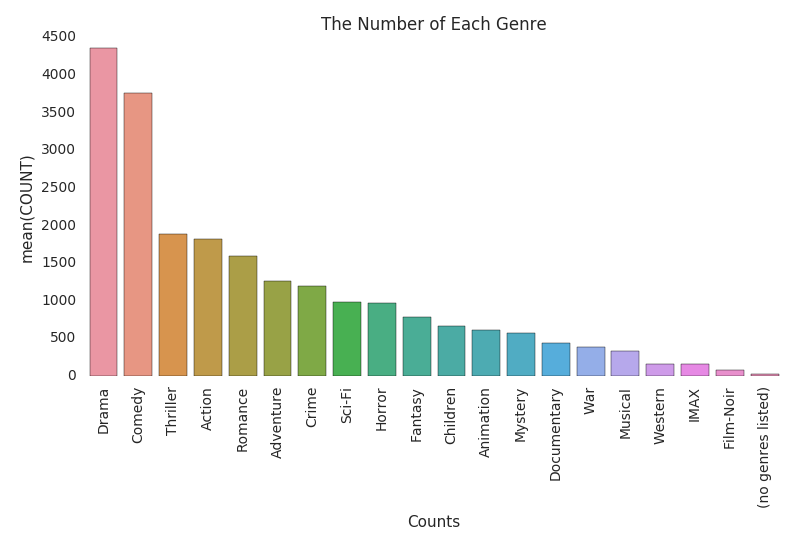

In [29]:
fig, axes = plt.subplots(1,1)
genres_count = num_of_each_genre.toPandas()
sns.barplot(y="COUNT", x="genres",data=genres_count,ax=axes)
plt.xlabel("Counts")
plt.title("The Number of Each Genre")
plt.xticks(rotation=90)
plt.tight_layout()
display(fig.show())

#### Data Distribution(Ratings)
In order to give a deep insight on the dataset, we need to analyze the distribution of 'Y' data-Ratings.

In [31]:
ratingsPD = ratings.toPandas()
moviesPD = movies.toPandas()
movie_data = pd.merge(ratingsPD, moviesPD, on = 'movieId')
movie_data.head(3)

Out[ 23 ]: 
 userId movieId rating timestamp title \
0 1 1 4.0 964982703 Toy Story (1995) 
1 5 1 4.0 847434962 Toy Story (1995) 
2 7 1 4.5 1106635946 Toy Story (1995) 

 genres 
0 Adventure|Animation|Children|Comedy|Fantasy 
1 Adventure|Animation|Children|Comedy|Fantasy 
2 Adventure|Animation|Children|Comedy|Fantasy

#### The number in each rating

In [33]:
num_rating=ratings.groupby('rating').count().orderBy('rating', ascending=False).toPandas()
type(num_rating)
display(num_rating)

rating,count
5.0,13211
4.5,8551
4.0,26818
3.5,13136
3.0,20047
2.5,5550
2.0,7551
1.5,1791
1.0,2811
0.5,1370


In [34]:
ratings1=ratings.toPandas()

In [35]:
ratings1['num_of_rating']=pd.DataFrame(ratings1.groupby('movieId')['rating'].count())
ratings1.head(10)

Out[ 26 ]: 
 userId movieId rating timestamp num_of_rating
0 1 1 4.0 964982703 NaN
1 1 3 4.0 964981247 NaN
2 1 6 4.0 964982224 NaN
3 1 47 5.0 964983815 NaN
4 1 50 5.0 964982931 NaN
5 1 70 3.0 964982400 NaN
6 1 101 5.0 964980868 NaN
7 1 110 4.0 964982176 NaN
8 1 151 5.0 964984041 NaN
9 1 157 5.0 964984100 NaN

In [36]:
type(num_rating)

Out[ 27 ]: pandas.core.frame.DataFrame

#### The mean rating of each User

In [38]:
user_rating=ratings.groupBy('userID').agg(mean('rating')).toPandas()
display(user_rating.head(10))

userID,avg(rating)
296,4.166666666666667
467,3.409090909090909
125,3.859722222222222
451,3.7941176470588234
7,3.2302631578947367
51,3.7757660167130918
124,3.99
447,3.871794871794872
591,3.2777777777777777
307,2.6656410256410257


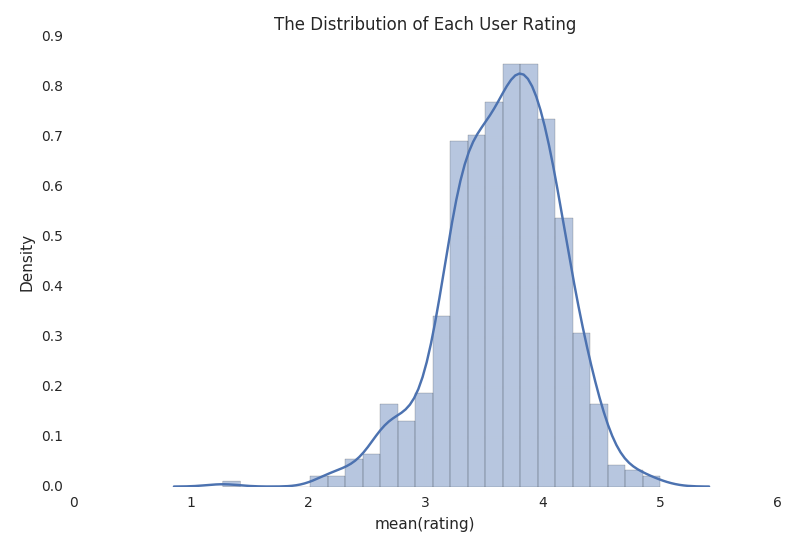

In [39]:
fig, axes = plt.subplots(1,1)
sns.distplot( user_rating["avg(rating)"] )
plt.xlabel("mean(rating)")
plt.ylabel("Density")
plt.title("The Distribution of Each User Rating")
plt.tight_layout()
display(fig.show())

#### The mean rating of each Movie

In [41]:
movie_rating=ratings.groupBy('MovieID').agg(mean('rating')).toPandas()
display(movie_rating.head(10))

MovieID,avg(rating)
296,4.197068403908795
1090,3.984126984126984
115713,3.9107142857142856
3210,3.4761904761904763
88140,3.546875
829,2.6666666666666665
2088,2.5
2294,3.2444444444444445
4821,3.1
48738,3.975


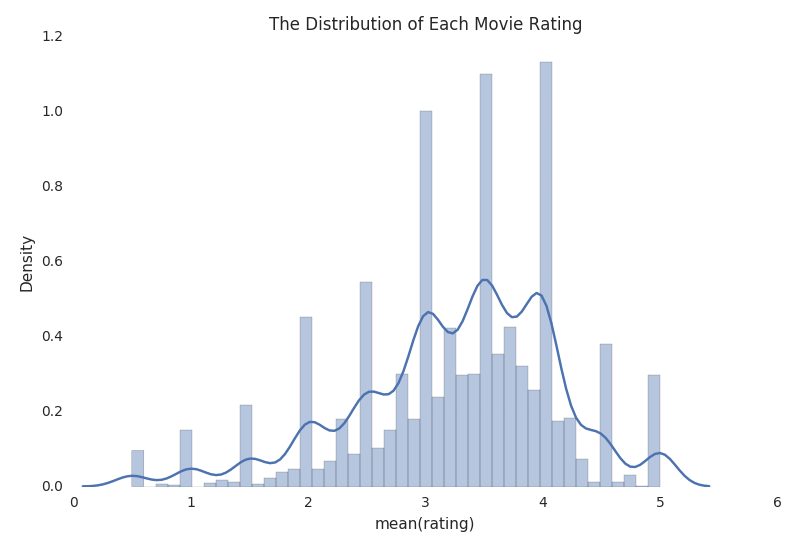

In [42]:
fig, axes = plt.subplots(1,1)
sns.distplot( movie_rating["avg(rating)"] )
plt.xlabel("mean(rating)")
plt.ylabel("Density")
plt.title("The Distribution of Each Movie Rating")
plt.tight_layout()
display(fig.show())



In [43]:
ratingsPD = ratings.toPandas()
moviesPD = movies.toPandas()
df_opt1 = pd.merge(ratingsPD, moviesPD, on = 'movieId')

In [44]:
df_opt1['rating'] = df_opt1['rating'].apply(pd.to_numeric) #convert to numeric value
df_opt1.groupby("title")["rating"].mean().sort_values(ascending = False).head(5) #groupBy("title"), apply aggregation function .mean() on "rating" column
df_opt1.groupby('title')['rating'].count().sort_values(ascending=False).head(5)

Out[ 33 ]: 
title
Forrest Gump (1994) 329
Shawshank Redemption, The (1994) 317
Pulp Fiction (1994) 307
Silence of the Lambs, The (1991) 279
Matrix, The (1999) 278
Name: rating, dtype: int64

In [45]:
title_ratings = pd.DataFrame(df_opt1.groupby('title')['rating'].mean())
title_ratings['num of ratings'] = pd.DataFrame(df_opt1.groupby('title')['rating'].count())
title_ratings.head(5)

Out[ 34 ]: 
 rating num of ratings
title 
"11'09""01 - September 11 (2002)" 4.0 2
'71 (2014) 4.0 1
'Hellboy': The Seeds of Creation (2004) 4.0 1
'Round Midnight (1986) 3.5 2
'Salem's Lot (2004) 5.0 1

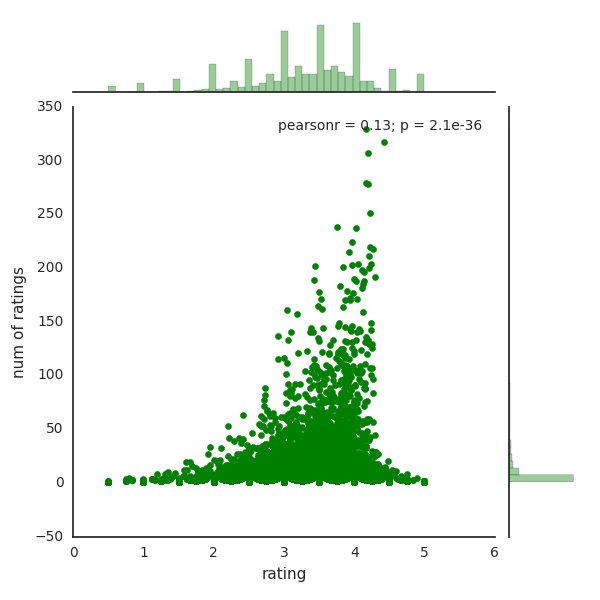

In [46]:
sns.set_style('white')
fig, ax = plt.subplots()
sns.jointplot(x = 'rating', y = 'num of ratings', data = title_ratings, color='g')
display(fig.show())

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

### Please refer to Spark ML ALS model
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/4999972933037924/899848065201823/8135547933712821/latest.html

In [49]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

ratings = ratings.select("userId", "movieId", "rating")
# inspect the schema 
ratings.printSchema()

root
-- userId: string (nullable = true)
-- movieId: string (nullable = true)
-- rating: string (nullable = true)

In [50]:
data_rating = ratings.withColumn('userId', ratings['userId'].cast('int')).\
withColumn('movieId', ratings['movieId'].cast('int')).withColumn('rating', ratings['rating'].cast('float'))
# inspect the schema 
data_rating.printSchema()

root
-- userId: integer (nullable = true)
-- movieId: integer (nullable = true)
-- rating: float (nullable = true)

In [51]:
display(data_rating)

userId,movieId,rating
1,1,4.0
1,3,4.0
1,6,4.0
1,47,5.0
1,50,5.0
1,70,3.0
1,101,5.0
1,110,4.0
1,151,5.0
1,157,5.0


Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [53]:
train, validation, test = data_rating.randomSplit([0.6,0.2,0.2],seed = 1)
print ("The number of ratings in each set: {}, {}, {}".format(train.count(), validation.count(), test.count()))

The number of ratings in each set: 60567, 20061, 20208

In [54]:
train.cache()

Out[ 40 ]: DataFrame[userId: int, movieId: int, rating: float]

In [55]:
validation.cache()

Out[ 41 ]: DataFrame[userId: int, movieId: int, rating: float]

In [56]:
test.cache()

Out[ 42 ]: DataFrame[userId: int, movieId: int, rating: float]

### Applied mean value of each movie as the prediction, and then we could compare the model performance between the mean-value model and the collaborative-fitering model accoring to Root Mean Square Erroe(rmse).

#### Applied Mean Value Model

In [59]:
mean_rating=train.groupby('movieId').mean().select('movieId','avg(rating)')
mean_rating = mean_rating.withColumnRenamed('avg(rating)','prediction')
mean_rating.count()
#display(mean_rating)
mean_rating.show(10)

+-------+------------------+
movieId| prediction|
+-------+------------------+
 2366| 3.764705882352941|
 1088| 3.46|
 1580| 3.442857142857143|
 32460| 4.0|
 44022|3.4583333333333335|
 96488| 4.333333333333333|
 1238| 3.9375|
 1591|2.6176470588235294|
 1645|3.4393939393939394|
 3175|3.5106382978723403|
+-------+------------------+
only showing top 10 rows

We could join the train table with test table on same movieId, and then caculate RMSE of the test data set

In [61]:
test.createOrReplaceTempView("test")
mean_rating.createOrReplaceTempView("mean_rating")

sqlDF = spark.sql("select test.*, mean_rating.prediction \
                   from test join mean_rating \
                   on test.movieId = mean_rating.movieId")
#display(sqlDF)
sqlDF.count()
sqlDF.show(5)

+------+-------+------+-----------------+
userId|movieId|rating| prediction|
+------+-------+------+-----------------+
 493| 2366| 2.0|3.764705882352941|
 448| 2366| 5.0|3.764705882352941|
 39| 2366| 5.0|3.764705882352941|
 600| 1088| 3.5| 3.46|
 583| 1088| 3.5| 3.46|
+------+-------+------+-----------------+
only showing top 5 rows

In [62]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
def RMSE(predictions):
    return evaluator.evaluate(predictions)

In [63]:
print ('Using the mean rating of each movie as the prediction, the testing RMSE is ' + str(RMSE(sqlDF)))

Using the mean rating of each movie as the prediction, the testing RMSE is 0.9684681096936459

#### Applied ALS Model

In [65]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_rmse = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # make prediction
            # get the rating result
            # get the RMSE
            als = ALS(rank = rank, 
                      maxIter = num_iterations, 
                      seed = 1, 
                      regParam = reg,
                      userCol="userId", 
                      itemCol="movieId", 
                      ratingCol="rating", 
                      coldStartStrategy="drop") 
            #error = None
            model = als.fit(train)
            predictions = model.transform(validation_data)
            #evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
            rmse = RMSE(predictions)
            
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_rmse:
                min_rmse = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    pred = best_model.transform(train)
    train_rmse = RMSE(pred)
    print ('traning RMSE is {}; validation RMSE is {}'.format(train_rmse, min_rmse))
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [66]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9766416162998439
6 latent factors and regularization = 0.1: validation RMSE is 0.9124975447342438
6 latent factors and regularization = 0.2: validation RMSE is 0.8937841733801742
6 latent factors and regularization = 0.4: validation RMSE is 0.9626450319320567
6 latent factors and regularization = 0.8: validation RMSE is 1.1811223220496179
8 latent factors and regularization = 0.05: validation RMSE is 0.9939192808387594
8 latent factors and regularization = 0.1: validation RMSE is 0.9168359026267469
8 latent factors and regularization = 0.2: validation RMSE is 0.8946289005096189
8 latent factors and regularization = 0.4: validation RMSE is 0.9624533854803139
8 latent factors and regularization = 0.8: validation RMSE is 1.181089011676798
10 latent factors and regularization = 0.05: validation RMSE is 1.0000582726052745
10 latent factors and regularization = 0.1: validation RMSE is 0.9196674701688281
10 latent factors and regularization = 0.2: validation RMSE is 0.8963509045007015
10 latent factors and regularization = 0.4: validation RMSE is 0.9625753196982241
10 latent factors and regularization = 0.8: validation RMSE is 1.1811131335784153
12 latent factors and regularization = 0.05: validation RMSE is 1.0087194992127675
12 latent factors and regularization = 0.1: validation RMSE is 0.9162178021866768
12 latent factors and regularization = 0.2: validation RMSE is 0.894727484888669
12 latent factors and regularization = 0.4: validation RMSE is 0.9628509915478566
12 latent factors and regularization = 0.8: validation RMSE is 1.1810974954336622
14 latent factors and regularization = 0.05: validation RMSE is 1.0147499730431686
14 latent factors and regularization = 0.1: validation RMSE is 0.9187622802761997
14 latent factors and regularization = 0.2: validation RMSE is 0.8952361734207187
14 latent factors and regularization = 0.4: validation RMSE is 0.9628224519860767
14 latent factors and regularization = 0.8: validation RMSE is 1.1811107621037311
traning RMSE is 0.6894984317476609; validation RMSE is 0.8937841733801742

The best model has 6 latent factors and regularization = 0.2
Total Runtime: 649.01 seconds

In [67]:
final_model

Out[ 53 ]: ALS_79c0b5a8e8a7

Select 3 numbers according to last model traing result and then Gradient Search again to find out the best hyper-parameter

In [69]:
num_iterations = 20
ranks = [5, 6, 7]
reg_params = [0.1, 0.2, 0.3]

final_model=train_ALS(train, validation, num_iterations, reg_params, ranks)

5 latent factors and regularization = 0.1: validation RMSE is 0.9129910146691529
5 latent factors and regularization = 0.2: validation RMSE is 0.8959979908871762
5 latent factors and regularization = 0.3: validation RMSE is 0.921484230227126
6 latent factors and regularization = 0.1: validation RMSE is 0.9111849889979121
6 latent factors and regularization = 0.2: validation RMSE is 0.8944181771079912
6 latent factors and regularization = 0.3: validation RMSE is 0.9211817900185335
7 latent factors and regularization = 0.1: validation RMSE is 0.9112996472460129
7 latent factors and regularization = 0.2: validation RMSE is 0.8951044358540294
7 latent factors and regularization = 0.3: validation RMSE is 0.921493898122112
traning RMSE is 0.6853796706283821; validation RMSE is 0.8944181771079912

The best model has 6 latent factors and regularization = 0.2

### Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [71]:
pred_test = final_model.transform(test)
print ('The testing RMSE is ' + str(RMSE(pred_test)))

The testing RMSE is 0.8884978333224407

### KEY OBSERVATION
- According to the RMSE result comparsion in test data set,  between Mean-Value model (0.9684681096936459) and Collaborative-Fitering model (0.8884978333224407), we could see that Collaborative-Fitering(ALS) model perform better than Mean-Value model.

- RMSE in the test dataset is 0.8884978333224407, even lower than the best performance validation (0.8959979908871762) data set, so I think the model performance is convinced. 

- The movie dataset is not large enough, so if this Collaborative-Fitering(ALS) model was trained in larger dataset, the final result could probably perform better. 

 ###Suggestions
 
 - Need more training data to cover more samples.
 - In order to make the model more reliable, we could add more features into the dataset.

#### References of ALS

- Building a Movie Recommendation Service: https://www.codementor.io/jadianes/building-a-recommender-with-apache-spark-python-example-app-part1-du1083qbw
- MLlib - Collaborative Filtering: https://spark.apache.org/docs/1.1.0/mllib-collaborative-filtering.html
- Collaborative Filtering - RDD-based API: https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html
- Evaluation Metrics - RDD-based API: https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html
- ML - ALS: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1